In [51]:
import numpy as np
import open3d as o3d

In [63]:
FILE = '/home/carlo/Documents/datasets/kitti-360//2013_05_28_drive_0000_sync_000386_000450/lidar_points_all.dat'
IMMAGINE = '/home/carlo/Documents/datasets/kitti-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect/0000000386.png'

In [53]:
sed = np.loadtxt(FILE, unpack = True)

In [54]:
sed.shape

(6, 362377)

In [55]:
pcl = o3d.PointCloud()

In [56]:
p = sed[:3, :]
p.shape

(3, 362377)

In [57]:
pose = np.array([0.6337552899, 0.7735143891, -0.0054518216, 977.5746237, 
                 0.7734979431, -0.6337780079, -0.0051350568, 3802.045638,
                 -0.007427285, -0.0009626034, -0.999971954, 115.0822819,
                0,0,0,1])
pose = pose.reshape((4, 4))
pcl_origin = o3d.PointCloud()

In [58]:
pose2 = np.array([])

In [59]:
calib = np.array([0.0371783278, -0.0986182135, 0.9944306009, 1.5752681039,
                  0.9992675562, -0.0053553387, -0.0378902567, 0.0043914093,
                  0.0090621821, 0.9951109327, 0.0983468786, -0.6500000000,
                 0,0,0,1])
calib = calib.reshape((4,4))
points_num = p.shape[1]
new_pts = np.vstack((p, np.ones((1, points_num))))

In [60]:
new_pts = np.dot(np.linalg.inv(pose), new_pts)
pcl_origin.points = o3d.Vector3dVector(new_pts[:3, :].T)
masd = o3d.geometry.create_mesh_coordinate_frame(
    size=5, origin=[0., 0., 0.])
# pointcloud nel sistema di coordinate velodyne del primo frame considerato, guardare quella pose (386)
o3d.visualization.draw_geometries([pcl_origin, masd])

In [61]:
camera_pts = np.dot(np.linalg.inv(calib), new_pts)
camera_pts = camera_pts[:3, :].T
pcl2 = o3d.PointCloud()
pcl2.points = o3d.Vector3dVector(camera_pts)
mesh_frame = o3d.geometry.create_mesh_coordinate_frame(
    size=10, origin=[0., 0., 0.])

In [103]:
# pointcloud nel sistema di coordianate camera per la pose (386)
o3d.visualization.draw_geometries([pcl2, mesh_frame])

In [65]:
print(camera_pts.shape)

(362377, 3)


In [100]:
# proiezione nel frame immagine Camera 0 prect0
k = np.array([552.554261, 0.000000, 682.049453, 0.000000, 
              0.000000, 552.554261, 238.769549, 0.000000, 
              0.000000, 0.000000, 1.000000, 0.000000])
k = k.reshape((3,4))
k

array([[552.554261,   0.      , 682.049453,   0.      ],
       [  0.      , 552.554261, 238.769549,   0.      ],
       [  0.      ,   0.      ,   1.      ,   0.      ]])

In [101]:
in_camera_pts = np.expand_dims(camera_pts.T, 0)
in_camera_pts.shape

(1, 3, 362377)

In [102]:
k[:3,:3].reshape([1,3,3])

array([[[552.554261,   0.      , 682.049453],
        [  0.      , 552.554261, 238.769549],
        [  0.      ,   0.      ,   1.      ]]])

In [73]:
points_proj = np.matmul(k[:3,:3].reshape([1,3,3]), in_camera_pts)
depth = points_proj[:,2,:]
depth[depth==0] = -1e-6
u = np.round(points_proj[:,0,:]/np.abs(depth)).astype(np.int)
v = np.round(points_proj[:,1,:]/np.abs(depth)).astype(np.int)

u = u[0]
v = v[0]
depth = depth[0]

/home/carlo/anaconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/home/carlo/anaconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to rev

In [104]:
depthMap = np.zeros((376, 1408))
depthImage = np.zeros((376, 1408, 3))
# valore della dimensione
mask = np.logical_and(np.logical_and(np.logical_and(u>=0, u<1408), v>=0), v<376)
# valore di profondita
mask = np.logical_and(np.logical_and(mask, depth>0), depth<35)
depthMap[v[mask],u[mask]] = depth[mask]

depthMap.shape

(376, 1408)

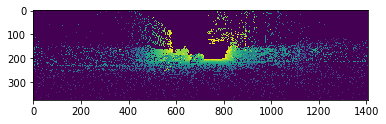

In [105]:
plt.imshow(depthMap, interpolation='nearest')
plt.show()